In [1]:
import os
os.environ["config"] = "/home/msun415/induction/src/config/ckt.yaml"
import sys
os.chdir('/home/msun415/induction/')
from src.examples import *
from src.draw.graph import draw_graph
from argparse import ArgumentParser
import pickle
import heapq
from src.grammar.ednce import *
from src.draw.graph import *
from src.api.get_motifs import *
from src.algo.utils import *
from src.algo.common import *
from src.grammar.common import *
from src.grammar.utils import *
from src.algo.ednce import *
from argparse import ArgumentParser
from networkx.algorithms.isomorphism import DiGraphMatcher
import pdb

/home/msun415/miniforge3/envs/ckt/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_data(args):
    if DATASET == "cora":
        g = load_cora()
    elif DATASET == "test":
        g = create_test_graph(1)
    elif DATASET == "debug":
        g = debug()
    elif DATASET == "house":
        g = create_house_graph()
    elif DATASET == "ckt":
        g = load_ckt(args)
    elif DATASET == "enas":
        g = load_enas(args)
    elif DATASET == "bn":
        g = load_bn(args)
    elif DATASET == "ast":
        g = load_ast(args)
    elif DATASET == "mol":
        g = load_mols(args)
    else:
        raise NotImplementedError
    return g
    
def get_args():
    parser = ArgumentParser()
    # global args
    parser.add_argument("--visualize", dest="global_visualize", action='store_true')
    parser.add_argument("--cache", dest="global_cache", action='store_true')    
    parser.add_argument("--num_threads", dest="global_num_threads", type=int)
    parser.add_argument("--num_procs", dest="global_num_procs", type=int)    
    # hparams
    parser.add_argument("--scheme", choices=['one','zero'], help='whether to index from 0 or 1', default='zero')    
    # ablations
    parser.add_argument("--ablate_tree", action='store_true') 
    parser.add_argument("--ablate_merge", action='store_true') 
    parser.add_argument("--ablate_root", action='store_true') 
    # task params
    parser.add_argument("--task", nargs='+', choices=["learn","generate","prediction"])
    parser.add_argument("--seed")
    parser.add_argument("--grammar_ckpt")
    # mol dataset args
    parser.add_argument(
        "--mol-dataset",
        choices=["ptc","hopv","polymers_117", "isocyanates", "chain_extenders", "acrylates"],
    )
    parser.add_argument(
        "--num-data-samples", type=int
    )
    parser.add_argument("--ambiguous-file", help='if given and exists, load data from this file to learn grammar; if given and not exist, save ambiguous data to this file after learn grammar')
    parser.add_argument("--num_samples", default=10000, type=int, help='how much to generate')
    return parser.parse_args([
        '--task', 'learn',
        '--ambiguous-file', 'cache/api_ckt_ednce/ambig_1.json'
    ])

In [3]:
args = get_args()
g = load_data(args)
orig = deepcopy(g)
cache_iter, cache_path = setup()
print(cache_path)
g, grammar, anno, iter = init_grammar(g, cache_iter, cache_path, EDNCEGrammar)
grammar, model, anno, g = terminate(g, grammar, anno, iter)
# for j, m in enumerate(model):
#     pre = get_prefix(m.id)
#     # draw_tree(m, os.path.join(IMG_DIR, f"model_{iter}_{pre}.png"))
#     model[j] = EDNCEModel(dfs(anno, m.id))
for j, m in enumerate(model):
    pre = get_prefix(m.id)
    # draw_tree(m, os.path.join(IMG_DIR, f"model_{iter}_{pre}.png"))
    model[j] = EDNCEModel(dfs(anno, m.id))
graphs = [copy_graph(orig, orig.comps[get_prefix(m.seq[0])]) for m in model]

loading graphs: 100%|██████████| 5000/5000 [00:02<00:00, 2036.10it/s]


cache/api_ckt_ednce/466.pkl


In [6]:
def worker_single(stack, grammar, graph, init_hash, mem, lock):
    while True:
        with lock:
            if len(stack) == 0:
                if init_hash in mem and mem[init_hash] != 0:
                    print("process done")                    
                break
            else:
                print(len(stack))
                cur, val = stack.pop(-1)
            if val in mem:
                if mem[val] != 0:
                    continue
            else:
                mem[val] = 0
        nts = grammar.search_nts(cur, NONTERMS)
        if len(nts) == 0:
            if nx.is_isomorphic(cur, graph, node_match=node_match):
                with lock: 
                    mem[val] = [[]]
            else:
                with lock:
                    mem[val] = []
            continue # done        
        done = True
        res = []
        for j, nt in enumerate(nts):
            for i, rule in enumerate(grammar.rules):                      
                if rule is None:
                    continue
                nt_label = cur.nodes[nt]['label']
                if rule.nt == nt_label:
                    c = rule(cur, nt)
                    if not nx.is_connected(nx.Graph(c)):
                        continue
                    if not nx.is_directed_acyclic_graph(c):
                        continue
                    exist = find_partial([graph], c)
                    if not exist:
                        continue
                    hash_val = wl_hash(c)
                    with lock:
                        if hash_val not in mem:
                            if done:
                                stack.append((cur, val))
                                done = False
                            stack.append((c, hash_val))                            
                        else:
                            if mem[hash_val] == 0:
                                if done:                                
                                    stack.append((cur, val))                            
                                    done = False
                            else:
                                for seq in mem[hash_val]: # res
                                    res.append([i]+deepcopy(seq))
        with lock:
            if done:        
                mem[val] = res 

In [7]:
def set_to_key(S):
    return tuple(sorted(list(S)))

def hitting(elim_sets, beam_width=100):
    H = []
    heapq.heappush(H, (0, set())) # priority=-len
    for S in elim_sets: # beam search
        # priority queue
        H_copy = list(H)
        H = []
        for _, h in H_copy: # copy
            for s in S:
                if len(H) < beam_width:
                    h_ = h|set([s])
                    heapq.heappush(H, (-len(h_), h_))
                else:
                    val_, h_ = heapq.heappop(H)
                    h__ = h|set([s])
                    if -val_ <= len(h_):
                        heapq.heappush(H, (val_, h_))
                    else:
                        heapq.heappush(H, (-len(h__), h__))
    while len(H)>1:
        heapq.heappop(H)
    l, ans = heapq.heappop(H)
    print(f"Input: {elim_sets}, Output: {ans}")
    return ans


def try_disambiguate(grammar, derivs):
    counts = {}
    for deriv in derivs:
        key = set_to_key(deriv)
        if key not in counts:
            counts[key] = []
        counts[key].append(deriv)
    elim_rule_sets = set()
    for key in counts:
        if len(counts[key]) == 1:
            keep_deriv = counts[key][0]
            elim_sets = set()
            for deriv in derivs:
                if deriv == keep_deriv:
                    continue
                elim_sets.add(set_to_key(set(deriv)-set(keep_deriv)))
            elim_rule_set = hitting(elim_sets)
            elim_rule_sets.add(set_to_key(elim_rule_set))
    # elim rule set
    min_num_remove = len(grammar.rules)
    min_remove = None
    for rule_set in elim_rule_sets:
        num_remove = 0
        for r in rule_set:
            if grammar.rules[r] is not None:
                num_remove += 1
        if num_remove < min_num_remove:
            min_num_remove = num_remove
            min_remove = rule_set
    if min_remove is None:
        min_remove = hitting(counts.keys())            
    return min_remove



In [4]:
### Novel graphs
g = nx.DiGraph()

## CKT
# Design
# g.add_node(0, label=LOOKUP['input'])
# g.add_node(1, label=LOOKUP['-gm+'])
# g.add_node(2, label=LOOKUP['C'])
# g.add_node(3, label=LOOKUP['+gm+'])
# g.add_node(4, label=LOOKUP['+gm+'])
# g.add_node(5, label=LOOKUP['output'])
# g.add_edge(0, 1)
# g.add_edge(0, 2)
# g.add_edge(1, 3)
# g.add_edge(2, 3)
# g.add_edge(3, 4)
# g.add_edge(4, 5)

# Design
# g.add_node(0, label=LOOKUP['input'])
# g.add_node(1, label=LOOKUP['-gm+'])
# g.add_node(2, label=LOOKUP['R'])
# g.add_node(3, label=LOOKUP['-gm+'])
# g.add_node(4, label=LOOKUP['output'])
# g.add_edge(0, 1)
# g.add_edge(1, 2)
# g.add_edge(1, 3)
# g.add_edge(2, 4)
# g.add_edge(3, 4)

## BN
# Design
g = nx.DiGraph() ; g.add_node('0', label=LOOKUP['input'], type='input') ; g.add_node('1', label=LOOKUP['A'], type='A') ; g.add_node('2', label=LOOKUP['S'], type='S') ; g.add_node('3', label=LOOKUP['T'], type='T') ; g.add_node('4', label=LOOKUP['L'], type='L') ; g.add_node('5', label=LOOKUP['E'], type='E') ; g.add_node('6', label=LOOKUP['B'], type='B') ; g.add_node('7', label=LOOKUP['X'], type='X') ; g.add_node('8', label=LOOKUP['D'], type='D') ; g.add_node('9', label=LOOKUP['output'], type='output') ; g.add_edge('0', '1', label='black') ; g.add_edge('0', '2', label='black') ; g.add_edge('1', '3', label='black') ; g.add_edge('2', '4', label='black') ; g.add_edge('3', '5', label='black') ; g.add_edge('4', '5', label='black') ; g.add_edge('2', '6', label='black') ; g.add_edge('5', '7', label='black') ; g.add_edge('5', '8', label='black') ; g.add_edge('6', '8', label='black') ; g.add_edge('7', '9', label='black') ; g.add_edge('8', '9', label='black') ; graphs = [g]

In [10]:
all_derivs = {}
index_graphs = [(i, graph) for i, graph in enumerate(graphs)]
sorted_graphs = sorted(index_graphs, key=lambda x:-len(x[1]))
for (index, graph) in sorted_graphs:
    manager = mp.Manager()
    stack = manager.list()
    mem = manager.dict()
    lock = manager.Lock()        
    g = nx.DiGraph()
    g.add_node('0', label='black')    
    init_hash = wl_hash(g)
    stack.append((deepcopy(g), init_hash))
    processes = []
    for _ in range(NUM_PROCS):
        p = mp.Process(target=worker_single, args=(stack, grammar, graph, init_hash, mem, lock))
        p.start()
        processes.append(p)
    for p in processes:
        p.join()    
    derivs = mem[init_hash]
    all_derivs[index] = derivs
    rule_set = try_disambiguate(grammar, derivs)
    n = len(list(filter(None, grammar.rules)))
    print(f"removing rules {rule_set}: {n}->{n-len(rule_set)}")
    for r in rule_set:        
        grammar.rules[r] = None

1
5
5
4
5
6
8
7
810

10
9
9
14
13
14
13
19
22
21
22
22
23
24
23
26
27
26
29
30
30
32
33
33
38
38
38
38
39
39
39
41
42
41
41
42
42
46
48
48
49
48
48
47
46
49
54
56
59
59
58
57
59
58
57
57
56
55
56
56
58
57
56
57
56
56
58
57
56
58
58
57
56
56
57
56
55
54
53
53
53
52
52
51
50
49
48
47
48
48
47
46
45
44
43
45
46
46
46
45
46
45
44
43
42
42
41
40
40
39
38
38
40
39
39
39
39
38
37
37
36
82
89
126
132
139
147
150
163
163
166
168
172
172
173
174
173
172
178
185
184
185
187
190
189
189
192
192
191
195
195
196
195
197
198
198
199
200
199
198
198
197
196
195
196
195
194
195
198
198
198
200
201
202
201
206
205
207
206
205
204
203
202
201
200
202
201
201
201
201
200
201
201
204
204
203
202
201
200
199
198
197
196
195
194
193
193
193
193
192
192
191
194
196
195
196
195
194
193
193
192
191
192
191
191
190
189
188
190
190
190
189
188
187
187
187
187
186
186
194
193
192
193
192
191
190
189
189
189
192
191
190
189
188
187
187
191
190
190
194
194
195
194
193
192
192
191
190
189
190
190
190
191
191
193
192


In [6]:
all_derivs

NameError: name 'all_derivs' is not defined

In [5]:
def draw_graph(
    g,
    path=None,
    scale=SCALE,
    node_size=NODE_SIZE,
    font_size=FONT_SIZE,
    layout=LAYOUT,
    label_feats=False,
    ax=None,
):
    conns = list(nx.connected_components(nx.Graph(g)))
    if len(conns) > 1:
        assert np.all(":" in n for n in g) or np.all(":" not in n for n in g)
        num_rows = int(np.sqrt(len(conns) - 1)) + 1
        num_cols = num_rows
        fig = plt.Figure(figsize=(num_rows * DIM_SCALE, num_cols * DIM_SCALE))
        for j, conn in enumerate(conns):
            ax_ = fig.add_subplot(num_rows, num_cols, j + 1)
            g_conn = copy_graph(g, conn)
            g_conn = g_conn.__class__(g_conn)  # deepcopy
            # if these conns are different graphs
            for key in g.graph:
                if ":" in key:
                    index, key_ = key.split(":")
                    index = int(index)
                    if index == j:
                        g_conn.graph[key_] = g.graph[key]
                else:
                    g_conn.graph[key] = g.graph[key]
            draw_graph(
                g_conn,
                path=path,
                scale=scale,
                node_size=node_size,
                font_size=font_size,
                layout=layout,
                ax=ax_,
            )
    else:
        if "layout" in g.graph:
            layout = g.graph["layout"]
        if layout == "spring_layout":
            pos = getattr(nx, layout)(nx.Graph(g), seed=SEED)
        else:
            pos = getattr(nx, layout)(nx.Graph(g))
        pos_np = np.array([v for v in pos.values()])
        w, l = pos_np.max(axis=0) - pos_np.min(axis=0)
        w = max(w, 1)
        l = max(l, 1)
        w, l = w + POS_EPSILON, l + POS_EPSILON
        if ax is None:
            fig = plt.Figure(figsize=(scale * w, scale * l))
            ax_ = fig.add_subplot(1, 1, 1)
        else:
            ax_ = ax
        if "scale" in g.graph:
            scale = g.graph["scale"]
        if "font_size" in g.graph:
            font_size = g.graph["font_size"]
        colors = []
        node_sizes = []
        for n in g:
            if "label" in g.nodes[n]:
                if g.nodes[n]['label'] == 'light_grey':
                    breakpoint()
                c = to_rgba(g.nodes[n]["label"])
            else:
                c = to_rgba("r")
            if "alpha" in g.nodes[n]:
                c = c[:-1] + (g.nodes[n]["alpha"],)
            if "node_size" in g.nodes[n]:
                n_size = g.nodes[n]["node_size"]
                node_sizes.append(n_size)
            else:
                node_sizes.append(node_size)
            colors.append(c)
        labels = {}
        for n in g:
            if (
                isinstance(n, str) and ":" in n
            ):  # used to denote which graph, not relevant
                n_ = n.split(":")[-1]
            else:
                n_ = n
            labels[n] = f"({n_})"
            if "type" in g.nodes[n]:
                type_ = g.nodes[n]["type"]
                labels[n] += f" {type_}"
            if label_feats and "feat" in g.nodes[n]:
                feat = g.nodes[n]["feat"]
                labels[n] += f" {feat}"
        nx.draw_networkx_nodes(
            g, ax=ax_, pos=pos, node_color=colors, node_size=node_sizes
        )
        nx.draw_networkx_labels(g, ax=ax_, pos=pos, labels=labels, font_size=font_size)
        for u, v, dic in g.edges(data=True):
            style = dic.get("style", "solid")
            alpha = dic.get("alpha", 1.0)
            if "label" in dic:
                label = dic["label"]
                loc = 0.5
                # arrowprops = dict(arrowstyle="->", color=label, lw=EDGE_THICKNESS)
                # mid = loc*pos[u]+(1-loc)*pos[v]
                # ax_.annotate('', xy=mid, xytext=pos[u], arrowprops=arrowprops)
                # ax_.text(mid[0], mid[1], '', fontsize=12, color=label)
                nx.draw_networkx_edges(
                    g,
                    ax=ax_,
                    pos=pos,
                    edgelist=[(u, v)],
                    style=style,
                    alpha=alpha,
                    edge_color=label,
                    width=EDGE_THICKNESS,
                    node_size=node_size,
                    arrowsize=ARROW_SIZE,
                    arrows=True,
                )
            else:
                label1 = dic["label1"]
                label2 = dic["label2"]
                loc1 = dic["loc1"]
                loc2 = dic["loc2"]
                rev1 = dic["reverse1"]
                rev2 = dic["reverse2"]
                print(
                    f"u={u} v={v}, passing label1={label1}, label2={label2}, loc1={loc1}, loc2={loc2}, reverse1={rev1}, reverse2={rev2}"
                )
                draw_custom_arrows(
                    ax_,
                    pos,
                    (u, v),
                    color_1=label1,
                    color_2=label2,
                    arrow_1_pos=loc1,
                    arrow_2_pos=loc2,
                    rev1=rev1,
                    rev2=rev2,
                )
        if "title" in g.graph:
            ax_.set_title(g.graph["title"], fontsize=TITLE_FONT_SIZE)
    if ax is None:
        if path is None:
            return fig
        else:
            os.makedirs(os.path.dirname(path), exist_ok=True)
            fig.savefig(path, bbox_inches="tight")
            print(os.path.abspath(path))

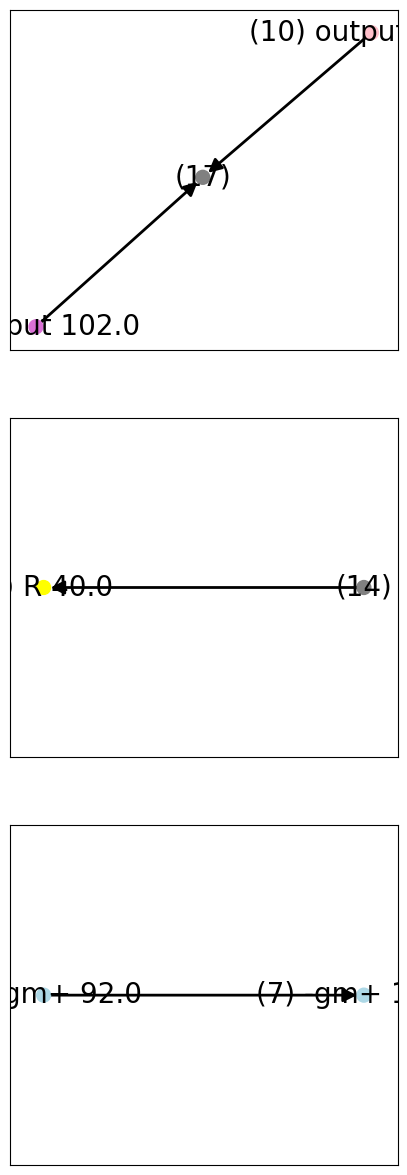

In [ ]:
%matplotlib inline
seq = [465, 334, 56]
fig, axes = plt.subplots(len(seq), figsize=(5, 5*(len(seq))))
if len(seq) == 1:
    axes = [axes]
for idx, j in enumerate(map(int, seq)):
    r = grammar.rules[j]
    draw_graph(r.subgraph, ax=axes[idx], scale=5, label_feats=True, node_size=2000, font_size=5)